## GPU Setting

In [40]:
import torch

# 檢查 M4 Pro (Apple Silicon) 的 MPS 加速
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available(): # 保留 CUDA 選項以便未來相容
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


# Config

In [41]:
config = {
    'dataset':{
        'train_ratio': 0.8,
        'sampling_rate': 256,
        'data_type': 'raw',
        'balance': False,
        'ictal_def': [15, 60]
    },
    'params':{
        'batch_size': 32,
        'class_weight': 0.9/0.1,
        'epoch': 80,
        'lr': 1e-4,
        'weight_decay': 1e-3,
        'alpha': 0.7,
        'gamma': 2,
        'threshold': 0.5
    },
    'eval':{
        'metrics': 'all',
        'save_metric': 'F1_score'
    }
}

# **INPUT DATA**

## Import Tools

In [42]:
from torch import nn
from torch.utils.data import DataLoader, random_split
import mne
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('main')
pl.seed_everything(42, workers=True)

Seed set to 42


42

## Preprocessing & Dataloader

Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2962557342.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


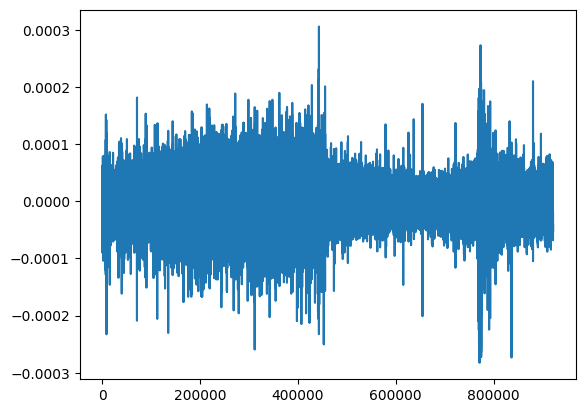

In [43]:
obj = "chb01_03"

file = f"CHB_EEG/{obj}.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
plt.plot(raw_data[1])

print(raw_data.shape)

In [44]:
# open json
with open(f"CHB_EEG/seizure_time_{config['dataset']['ictal_def'][0]}_{config['dataset']['ictal_def'][1]}.json", 'r') as f:
  seizure_time = json.load(f)
items = list(seizure_time.items())

# devide datasets
train_eeg_signal = []
for (obj, info) in items[3:21]:
  file = f"CHB_EEG/{obj}.edf"
  data = mne.io.read_raw_edf(file)
  raw_data = data.get_data()
  print(raw_data.shape)
  train_eeg_signal.append(raw_data)
train_timepoints = items[3:21]

val_eeg_signal = []
for (obj, info) in items[:3]:
  file = f"CHB_EEG/{obj}.edf"
  data = mne.io.read_raw_edf(file)
  raw_data = data.get_data()
  print(raw_data.shape)
  val_eeg_signal.append(raw_data)
val_timepoints = items[:3]

test_eeg_signal = []
for (obj, info) in items[21:]:
  file = f"CHB_EEG/{obj}.edf"
  data = mne.io.read_raw_edf(file)
  raw_data = data.get_data()
  print(raw_data.shape)
  test_eeg_signal.append(raw_data)
test_timepoints = items[21:]

Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_04.edf...
EDF file detected


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 681728)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 595200)


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_7063/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


In [45]:
from dataset import MFCCDataset, RawDataset

if config['dataset']['data_type'] == 'MFCC':
  dataset = MFCCDataset(eeg_signal, ontime)

  train_size = int(config['dataset']['train_ratio'] * len(dataset))
  val_size   = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print(len(train_dataset), len(val_dataset))

  # test dataset
  eeg_signal = []
  ontime = []
  for (obj, info) in items[:1]:
    file = f"CHB_EEG/{obj}.edf"
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    print(raw_data.shape)
    eeg_signal.append(raw_data)
    ontime.append(info['seizure_start_time'])
  test_dataset = MFCCDataset(eeg_signal, ontime)
  print(len(test_dataset))
  print(ontime)

elif config['dataset']['data_type'] == 'raw':
  train_dataset = RawDataset(train_eeg_signal, train_timepoints, mode='train', balance=config['dataset']['balance'])
  val_dataset = RawDataset(val_eeg_signal, val_timepoints, mode='val')
  test_dataset = RawDataset(test_eeg_signal, test_timepoints, mode='test')

print("Before downsampling:")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Before downsampling:
Train: 7800, Val: 1500, Test: 2630


In [46]:
# Downsample negative samples to balance the dataset (1:1 ratio)
def downsample_negative_samples(dataset, random_seed=42):
    """
    Downsample negative samples to match the number of positive samples.
    Returns a new dataset with balanced classes.
    """
    np.random.seed(random_seed)

    # Get all labels
    labels = np.array([dataset[i][1] for i in range(len(dataset))])

    # Find indices of positive and negative samples
    pos_indices = np.where(labels == 1)[0]
    neg_indices = np.where(labels == 0)[0]

    print(f"Original - Positive: {len(pos_indices)}, Negative: {len(neg_indices)}, Ratio: {len(neg_indices)/len(pos_indices):.2f}:1")

    # If no positive samples, return original dataset
    if len(pos_indices) == 0:
        print("Warning: No positive samples found, returning original dataset")
        return dataset

    # Randomly sample negative indices to match positive count
    if len(neg_indices) > len(pos_indices):
        sampled_neg_indices = np.random.choice(neg_indices, size=len(pos_indices), replace=False)
    else:
        sampled_neg_indices = neg_indices

    # Combine positive and sampled negative indices
    balanced_indices = np.concatenate([pos_indices, sampled_neg_indices])
    np.random.shuffle(balanced_indices)  # Shuffle to mix classes

    # Create new balanced dataset
    balanced_data = [dataset.data[i] for i in balanced_indices]
    balanced_labels = [dataset.label[i] for i in balanced_indices]

    # Create a simple dataset-like object or update existing dataset
    class BalancedDataset:
        def __init__(self, data, labels):
            self.data = data
            self.label = labels

        def __len__(self):
            return len(self.label)

        def __getitem__(self, idx):
            return self.data[idx], self.label[idx]

    balanced_dataset = BalancedDataset(balanced_data, balanced_labels)

    # Verify balance
    balanced_labels_check = np.array([balanced_dataset[i][1] for i in range(len(balanced_dataset))])
    pos_count = np.sum(balanced_labels_check == 1)
    neg_count = np.sum(balanced_labels_check == 0)
    print(f"Balanced - Positive: {pos_count}, Negative: {neg_count}, Ratio: {neg_count/pos_count:.2f}:1")

    return balanced_dataset

# Apply downsampling to training dataset only (keep val/test original for realistic evaluation)
print("\nDownsampling training dataset...")
train_dataset = downsample_negative_samples(train_dataset, random_seed=42)

print(f"\nAfter downsampling:")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Downsampling training dataset...
Original - Positive: 851, Negative: 6949, Ratio: 8.17:1
Balanced - Positive: 851, Negative: 851, Ratio: 1.00:1

After downsampling:
Train: 1702, Val: 1500, Test: 2630


In [47]:
def normalize_per_sample(data_list):
    """Normalize each sample independently to avoid distribution shift"""
    normalized = []
    for sample in data_list:
        sample_flat = sample.flatten()
        mean = np.mean(sample_flat)
        std = np.std(sample_flat)
        if std > 1e-8:  # avoid division by zero
            normalized.append((sample - mean) / std)
        else:
            normalized.append(sample)
    return normalized

print("Normalizing data per-sample (each window independently)...")
train_dataset.data = normalize_per_sample(train_dataset.data)
val_dataset.data = normalize_per_sample(val_dataset.data)
test_dataset.data = normalize_per_sample(test_dataset.data)
print("Normalization complete")

Normalizing data per-sample (each window independently)...
Normalization complete


In [48]:
'''
X_train = np.array(train_dataset.data)
X_val   = np.array(val_dataset.data)
X_test  = np.array(test_dataset.data)

X_train = X_train.reshape(X_train.shape[0], -1)
X_val   = X_val.reshape(X_val.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

train_dataset.data = X_train
val_dataset.data   = X_val
test_dataset.data  = X_test
'''

'\nX_train = np.array(train_dataset.data)\nX_val   = np.array(val_dataset.data)\nX_test  = np.array(test_dataset.data)\n\nX_train = X_train.reshape(X_train.shape[0], -1)\nX_val   = X_val.reshape(X_val.shape[0], -1)\nX_test  = X_test.reshape(X_test.shape[0], -1)\n\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_val   = scaler.transform(X_val)\nX_test  = scaler.transform(X_test)\n\ntrain_dataset.data = X_train\nval_dataset.data   = X_val\ntest_dataset.data  = X_test\n'

In [49]:
# count positive and negative samples
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
label_counts = Counter(labels)
label_counts = Counter({int(k): v for k, v in label_counts.items()})
total = sum(label_counts.values())
label_ratio = {int(k): v / total for k, v in label_counts.items()}


print(f'train dataset: {label_counts, label_ratio}')
labels = [val_dataset[i][1] for i in range(len(val_dataset))]
label_counts = Counter(labels)
label_counts = Counter({int(k): v for k, v in label_counts.items()})
total = sum(label_counts.values())
label_ratio = {int(k): v / total for k, v in label_counts.items()}


print(f'val dataset: {label_counts, label_ratio}')
labels = [test_dataset[i][1] for i in range(len(test_dataset))]
label_counts = Counter(labels)
label_counts = Counter({int(k): v for k, v in label_counts.items()})
total = sum(label_counts.values())
label_ratio = {int(k): v / total for k, v in label_counts.items()}

print(f'test dataset: {label_counts, label_ratio}')

train dataset: (Counter({1: 851, 0: 851}), {1: 0.5, 0: 0.5})
val dataset: (Counter({0: 1320, 1: 180}), {0: 0.88, 1: 0.12})
test dataset: (Counter({0: 2450, 1: 180}), {0: 0.9315589353612167, 1: 0.06844106463878327})


In [50]:
train_loader = DataLoader(train_dataset, batch_size=config['params']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['params']['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['params']['batch_size'], shuffle=False)

In [51]:
# Create weighted sampler to handle class imbalance (1:9 ratio)
from torch.utils.data import WeightedRandomSampler

# Calculate class weights for sampling
train_labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
class_counts = np.bincount(train_labels.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels.astype(int)]
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Use sampler for train (balances batches), no sampler for val/test
train_loader = DataLoader(
    train_dataset,
    batch_size=config['params']['batch_size'],
    sampler=weighted_sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['params']['batch_size'],
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['params']['batch_size'],
    shuffle=False
)

In [52]:
next(iter(train_loader))[0].shape

torch.Size([32, 23, 1280])

# **MODEL**

## MLP

In [53]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Dropout(p=0.3)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

## CNN

In [54]:
class CNN_MLP(nn.Module):
    """
    CNN feature extractor followed by MLP classifier.
    Architecture:
    - 4 Conv2d layers (32 kernels each, kernel_size=3x2)
    - 3 MaxPool2d layers (pool_size=2x2)
    - BatchNorm + ReLU after each conv
    - MLP classifier (300->100->50->20->1)
    """
    def __init__(self, input_channels=23, input_time=1280, dropout_p=0.3):
        """
        Args:
            input_channels: Number of EEG channels (default 23)
            input_time: Time points per sample (5 sec * 256 Hz = 1280)
            dropout_p: Dropout probability (not used in CNN, kept for compatibility)
        """
        super(CNN_MLP, self).__init__()

        # CNN Feature Extractor
        # Input: (batch, 1, channels, time)
        # Conv1: 1 -> 32 kernels, kernel_size=(3, 2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv2: 32 -> 32 kernels, kernel_size=(3, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv3: 32 -> 32 kernels, kernel_size=(3, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv4: 32 -> 32 kernels, kernel_size=(3, 2) (no pooling after this)
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        dummy_x = torch.zeros(1, input_channels, input_time)
        dummy_x = dummy_x.unsqueeze(0) if dummy_x.ndim == 3 else dummy_x  # (1, 23, 1280) -> (1, 23, 1280)
        x = self.conv1(dummy_x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        flatten_size = x.numel()
        self.mlp = nn.Sequential(
            nn.Linear(flatten_size, 300),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 20),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        # 1. 修正：將 (B, C, T) 轉為 (B, 1, C, T) 以符合 Conv2d 輸入
        # (B=batch_size, C=channels, T=time)
        x = x.unsqueeze(1)

        # CNN Feature Extraction
        # 4 conv layers + 3 maxpool layers
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)

        # Flatten for MLP
        x = x.view(x.size(0), -1)

        # 2. 修正：移除多餘的 if 區塊 (self.mlp 已在 __init__ 中定義)
        # if self.mlp is None:
        #     ...

        # MLP Classification
        x = self.mlp(x)
        return x

## EEGNet

In [55]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, (1, 64), padding = 0),
            nn.ELU(),
            nn.BatchNorm2d(16, False),
            nn.Dropout(0.25)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            nn.ZeroPad2d((16, 17, 0, 1)),
            nn.Conv2d(1, 4, (2, 32)),
            nn.ELU(),
            nn.BatchNorm2d(4, False),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 4)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            nn.ZeroPad2d((2, 1, 4, 3)),
            nn.Conv2d(4, 4, (8, 4)),
            nn.ELU(),
            nn.BatchNorm2d(4, False),
            nn.Dropout(0.25),
            nn.MaxPool2d((2, 4))
        )

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints.
        self.fc1 = nn.Linear(4*2*7, 1)


    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.layer2(x)

        # Layer 3
        x = self.layer3(x)

        # FC Layer
        x = x.view(-1, 4*2*7)
        x = nn.sigmoid(self.fc1(x))
        return x

## DCNN_BiLSTM

In [56]:
class DCNN_BiLSTM(nn.Module):
    def __init__(self, input_channels=23, input_time=1280):
        super(DCNN_BiLSTM, self).__init__()

        # ------------------------------------------------------
        # 1. DCNN 前端 (完全複製您之前的成功架構)
        # ------------------------------------------------------
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # [新增] 空間 Dropout (針對 CNN 特徵)
        # p=0.1 代表有 10% 的 Feature Maps 會被隨機歸零
        self.dropout2d = nn.Dropout2d(p=0.1)

        # ------------------------------------------------------
        # 2. 自動計算 CNN 輸出維度 (為了銜接 LSTM)
        # ------------------------------------------------------
        # 我們跑一次假資料，看看 CNN 輸出形狀是什麼
        with torch.no_grad():
            dummy_x = torch.zeros(1, 1, input_channels, input_time)
            x = self.conv1(dummy_x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = self.conv3(x)
            x = self.pool(x)
            x = self.conv4(x)
            # CNN 輸出形狀: (Batch, Out_Channels, Height, Width)
            # 我們將 Width 視為 "時間步長 (Time Steps)"
            # 將 Out_Channels * Height 視為 "特徵數 (Features)"
            self.lstm_input_size = x.shape[1] * x.shape[2] 
            self.lstm_seq_len = x.shape[3]
            print(f"CNN Output Shape: {x.shape}")
            print(f"LSTM Input Features: {self.lstm_input_size}, Seq Len: {self.lstm_seq_len}")

        # ------------------------------------------------------
        # 3. Bi-LSTM 後端 (根據論文設置)
        # ------------------------------------------------------
        # [cite_start]論文參數: hidden_size=20, bidirectional=True [cite: 2]
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size, 
            hidden_size=20, 
            num_layers=1, 
            bidirectional=True, 
            batch_first=True
        )

        # 4. 最終分類器
        # 因為是雙向 (Bidirectional)，輸出維度是 hidden_size * 2
        self.fc = nn.Sequential(
            nn.Linear(20 * 2, 1) # 40 -> 1
        )
        
        # 論文提到的 Dropout (可選)
        self.dropout = nn.Dropout(0.75)

    def forward(self, x):
        # 1. 維度調整: (B, C, T) -> (B, 1, C, T)
        x = x.unsqueeze(1)

        # 2. DCNN 特徵提取
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        # 此時 x 的形狀: (Batch, 32, H, W)

        # 3. 重塑 (Reshape) 給 LSTM
        # 我們需要將維度轉為 (Batch, Time_Steps, Features)
        # Time_Steps = W, Features = 32 * H
        x = x.permute(0, 3, 1, 2) # 變成 (Batch, W, 32, H)
        x = x.reshape(x.size(0), x.size(1), -1) # 變成 (Batch, W, 32*H)

        # 4. Bi-LSTM 處理
        # lstm_out: (Batch, Seq_Len, Hidden_Size*2)
        lstm_out, _ = self.lstm(x)

        # 5. 取最後一個時間點的輸出
        # (論文架構圖顯示是在處理完序列後分類)
        x = lstm_out[:, -1, :] 
        
        x = self.dropout(x)

        # 6. 最終分類
        x = self.fc(x)
        return x

# **Training Pipeline**

In [57]:
# Training with best-threshold selection on validation
from sklearn.metrics import f1_score
import numpy as np
from metrics import basic_metric
from focal_loss import FocalLoss

pl.seed_everything(42, workers=True)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def pick_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0.05, 0.95, 19)
    scores = []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        try:
            score = f1_score(y_true, preds)
        except Exception:
            score = 0.0
        scores.append((t, score))
    return max(scores, key=lambda x: x[1])

input_shape = next(iter(train_loader))[0].shape
# model = MLP(input_size=input_shape[1]).to(device)
# model = MLP(input_size=input_shape[1]*input_shape[2]).to(device)
# model = CNN_MLP(input_channels=input_shape[1], input_time=input_shape[2]).to(device)

# 使用新的 Bi-LSTM 模型
model = DCNN_BiLSTM(input_channels=input_shape[1], input_time=input_shape[2]).to(device)

# pos_weight = torch.tensor([config['params']['class_weight']])
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=config['params']['gamma'], alpha=config['params']['alpha'], task_type='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=config['params']['lr'], weight_decay=config['params']['weight_decay'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

epochs = config['params']['epoch']
best_score, best_epoch = 0, 0
best_loss, best_loss_epoch = 1e9, 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}--------------------------")
    model.train()
    train_loss = 0.0
    y_true_t, y_prob_t, y_pred_t = [], [], []
    for X, y in tqdm(train_loader):
        X = X.float().to(device)
        y = y.float().to(device)

        # ==========================================
        # [新增] 注入微量高斯雜訊 (Gaussian Noise)
        # ==========================================
        if model.training:
            # 0.01 是雜訊強度 (Standard Deviation)
            # 您可以試試 0.005 ~ 0.02 之間
            noise = torch.randn_like(X) * 0.01  
            X = X + noise
        # ==========================================

        logits = model(X).view(-1)
        loss = criterion(logits, y)
        train_loss += loss.item() * y.shape[0]
        optimizer.zero_grad()
        loss.backward()

        # [新增] 梯度裁剪：限制梯度最大範數為 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        probs = torch.sigmoid(logits)
        y_true_t.extend(y.cpu().numpy())
        y_prob_t.extend(probs.detach().cpu().numpy().reshape(-1))
        y_pred_t.extend((probs >= config['params']['threshold']).long().cpu().numpy().reshape(-1))

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    print(f"Train loss: {train_loss:.5f}")
    _ = basic_metric(y_true_t, y_pred_t, y_prob_t, metrics=['f1_score', 'accuracy', 'fpr'])

    # Validation with best threshold
    model.eval()
    val_loss = 0.0
    y_true_v, y_prob_v = [], []
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            logits = model(X).view(-1)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.shape[0]
            probs = torch.sigmoid(logits)
            y_true_v.extend(y.cpu().numpy())
            y_prob_v.extend(probs.detach().cpu().numpy().reshape(-1))

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    print(f"Val loss: {val_loss:.5f}")

    scheduler.step(val_loss)

    y_true_np = np.array(y_true_v)
    y_prob_np = np.array(y_prob_v)
    best_t, best_f1 = pick_best_threshold(y_true_np, y_prob_np)
    print(f"Val best threshold: {best_t:.2f}, F1: {best_f1:.4f}")
    y_pred_v = (y_prob_np >= best_t).astype(int).tolist()

    val_results = basic_metric(y_true_np, y_pred_v, y_prob_np, metrics=['all'])

    # Save by chosen metric and by loss
    if val_results[config['eval']['save_metric']] > best_score:
        best_score = val_results[config['eval']['save_metric']]
        torch.save(model.state_dict(), 'best_model.pth')
        print('model saved (best metric)')
        best_epoch = epoch + 1
        config['eval']['threshold_best'] = best_t
    if val_loss < best_loss:
        best_loss = val_loss
        best_loss_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_loss_model.pth')
        print('model saved (best loss)')
        config['eval']['threshold_bestloss'] = best_t

# Always save last
torch.save(model.state_dict(), 'last_model.pth')
config['eval']['threshold_last'] = best_t
print('model saved (last)')
print(f'best epoch: {best_epoch}')
print(f'best loss epoch: {best_loss_epoch}')
print(f'best-F1 threshold: {config["eval"]["threshold_best"]}')
print(f'best-loss threshold: {config["eval"]["threshold_bestloss"]}')

Seed set to 42


CNN Output Shape: torch.Size([1, 32, 2, 158])
LSTM Input Features: 64, Seq Len: 158
Total parameters: 32809
Epoch: 1--------------------------


100%|██████████| 54/54 [00:02<00:00, 24.04it/s]


Train loss: 0.67523
accuracy: 0.5734
F1_score: 0.5989
fpr     : 0.4815


100%|██████████| 47/47 [00:00<00:00, 95.83it/s]


Val loss: 0.67174
Val best threshold: 0.50, F1: 0.3425
accuracy   : 0.5673
recall     : 0.9389
precision  : 0.2094
specificity: 0.5167
AUC        : 0.8568
F1_score   : 0.3425
fpr        : 0.4833
model saved (best metric)
model saved (best loss)
Epoch: 2--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.08it/s]


Train loss: 0.62236
accuracy: 0.7092
F1_score: 0.7137
fpr     : 0.3356


100%|██████████| 47/47 [00:00<00:00, 109.00it/s]


Val loss: 0.62669
Val best threshold: 0.55, F1: 0.6222
accuracy   : 0.8980
recall     : 0.7000
precision  : 0.5600
specificity: 0.9250
AUC        : 0.9340
F1_score   : 0.6222
fpr        : 0.0750
model saved (best metric)
model saved (best loss)
Epoch: 3--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.21it/s]


Train loss: 0.54585
accuracy: 0.8179
F1_score: 0.8212
fpr     : 0.2325


100%|██████████| 47/47 [00:00<00:00, 109.24it/s]


Val loss: 0.59460
Val best threshold: 0.60, F1: 0.6872
accuracy   : 0.9053
recall     : 0.8667
precision  : 0.5693
specificity: 0.9106
AUC        : 0.9519
F1_score   : 0.6872
fpr        : 0.0894
model saved (best metric)
model saved (best loss)
Epoch: 4--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.87it/s]


Train loss: 0.47528
accuracy: 0.8684
F1_score: 0.8739
fpr     : 0.1761


100%|██████████| 47/47 [00:00<00:00, 109.56it/s]


Val loss: 0.57907
Val best threshold: 0.70, F1: 0.7156
accuracy   : 0.9173
recall     : 0.8667
precision  : 0.6094
specificity: 0.9242
AUC        : 0.9619
F1_score   : 0.7156
fpr        : 0.0758
model saved (best metric)
model saved (best loss)
Epoch: 5--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.38it/s]


Train loss: 0.42668
accuracy: 0.8872
F1_score: 0.8914
fpr     : 0.1585


100%|██████████| 47/47 [00:00<00:00, 109.81it/s]


Val loss: 0.53498
Val best threshold: 0.75, F1: 0.7127
accuracy   : 0.9140
recall     : 0.8889
precision  : 0.5948
specificity: 0.9174
AUC        : 0.9628
F1_score   : 0.7127
fpr        : 0.0826
model saved (best loss)
Epoch: 6--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.38it/s]


Train loss: 0.36906
accuracy: 0.9125
F1_score: 0.9139
fpr     : 0.1241


100%|██████████| 47/47 [00:00<00:00, 108.69it/s]


Val loss: 0.45941
Val best threshold: 0.80, F1: 0.7373
accuracy   : 0.9273
recall     : 0.8500
precision  : 0.6511
specificity: 0.9379
AUC        : 0.9675
F1_score   : 0.7373
fpr        : 0.0621
model saved (best metric)
model saved (best loss)
Epoch: 7--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.17it/s]


Train loss: 0.30761
accuracy: 0.9418
F1_score: 0.9437
fpr     : 0.0829


100%|██████████| 47/47 [00:00<00:00, 109.29it/s]


Val loss: 0.40632
Val best threshold: 0.80, F1: 0.7325
accuracy   : 0.9187
recall     : 0.9278
precision  : 0.6051
specificity: 0.9174
AUC        : 0.9698
F1_score   : 0.7325
fpr        : 0.0826
model saved (best loss)
Epoch: 8--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.26it/s]


Train loss: 0.27711
accuracy: 0.9477
F1_score: 0.9491
fpr     : 0.0756


100%|██████████| 47/47 [00:00<00:00, 108.81it/s]


Val loss: 0.39403
Val best threshold: 0.85, F1: 0.7321
accuracy   : 0.9200
recall     : 0.9111
precision  : 0.6119
specificity: 0.9212
AUC        : 0.9693
F1_score   : 0.7321
fpr        : 0.0788
model saved (best loss)
Epoch: 9--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.20it/s]


Train loss: 0.24680
accuracy: 0.9530
F1_score: 0.9529
fpr     : 0.0731


100%|██████████| 47/47 [00:00<00:00, 108.96it/s]


Val loss: 0.38877
Val best threshold: 0.85, F1: 0.7269
accuracy   : 0.9113
recall     : 0.9833
precision  : 0.5765
specificity: 0.9015
AUC        : 0.9678
F1_score   : 0.7269
fpr        : 0.0985
model saved (best loss)
Epoch: 10--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.16it/s]


Train loss: 0.21242
accuracy: 0.9665
F1_score: 0.9658
fpr     : 0.0476


100%|██████████| 47/47 [00:00<00:00, 109.40it/s]


Val loss: 0.39002
Val best threshold: 0.90, F1: 0.7260
accuracy   : 0.9240
recall     : 0.8389
precision  : 0.6398
specificity: 0.9356
AUC        : 0.9643
F1_score   : 0.7260
fpr        : 0.0644
Epoch: 11--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.18it/s]


Train loss: 0.20205
accuracy: 0.9630
F1_score: 0.9642
fpr     : 0.0584


100%|██████████| 47/47 [00:00<00:00, 109.00it/s]


Val loss: 0.34985
Val best threshold: 0.90, F1: 0.7375
accuracy   : 0.9193
recall     : 0.9444
precision  : 0.6050
specificity: 0.9159
AUC        : 0.9659
F1_score   : 0.7375
fpr        : 0.0841
model saved (best metric)
model saved (best loss)
Epoch: 12--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.49it/s]


Train loss: 0.19289
accuracy: 0.9665
F1_score: 0.9679
fpr     : 0.0531


100%|██████████| 47/47 [00:00<00:00, 108.15it/s]


Val loss: 0.31622
Val best threshold: 0.90, F1: 0.7571
accuracy   : 0.9260
recall     : 0.9611
precision  : 0.6245
specificity: 0.9212
AUC        : 0.9677
F1_score   : 0.7571
fpr        : 0.0788
model saved (best metric)
model saved (best loss)
Epoch: 13--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.11it/s]


Train loss: 0.17494
accuracy: 0.9689
F1_score: 0.9688
fpr     : 0.0495


100%|██████████| 47/47 [00:00<00:00, 109.23it/s]


Val loss: 0.29804
Val best threshold: 0.90, F1: 0.7716
accuracy   : 0.9293
recall     : 0.9944
precision  : 0.6303
specificity: 0.9205
AUC        : 0.9695
F1_score   : 0.7716
fpr        : 0.0795
model saved (best metric)
model saved (best loss)
Epoch: 14--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.19it/s]


Train loss: 0.15272
accuracy: 0.9736
F1_score: 0.9736
fpr     : 0.0428


100%|██████████| 47/47 [00:00<00:00, 108.77it/s]


Val loss: 0.30101
Val best threshold: 0.90, F1: 0.7505
accuracy   : 0.9220
recall     : 0.9778
precision  : 0.6090
specificity: 0.9144
AUC        : 0.9677
F1_score   : 0.7505
fpr        : 0.0856
Epoch: 15--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.01it/s]


Train loss: 0.15400
accuracy: 0.9671
F1_score: 0.9677
fpr     : 0.0428


100%|██████████| 47/47 [00:00<00:00, 108.88it/s]


Val loss: 0.22318
Val best threshold: 0.90, F1: 0.7886
accuracy   : 0.9407
recall     : 0.9222
precision  : 0.6888
specificity: 0.9432
AUC        : 0.9747
F1_score   : 0.7886
fpr        : 0.0568
model saved (best metric)
model saved (best loss)
Epoch: 16--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.10it/s]


Train loss: 0.13905
accuracy: 0.9706
F1_score: 0.9712
fpr     : 0.0437


100%|██████████| 47/47 [00:00<00:00, 109.20it/s]


Val loss: 0.34257
Val best threshold: 0.90, F1: 0.7262
accuracy   : 0.9100
recall     : 0.9944
precision  : 0.5719
specificity: 0.8985
AUC        : 0.9669
F1_score   : 0.7262
fpr        : 0.1015
Epoch: 17--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.05it/s]


Train loss: 0.16262
accuracy: 0.9612
F1_score: 0.9620
fpr     : 0.0566


100%|██████████| 47/47 [00:00<00:00, 108.72it/s]


Val loss: 0.31875
Val best threshold: 0.90, F1: 0.7366
accuracy   : 0.9147
recall     : 0.9944
precision  : 0.5850
specificity: 0.9038
AUC        : 0.9667
F1_score   : 0.7366
fpr        : 0.0962
Epoch: 18--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.12it/s]


Train loss: 0.13305
accuracy: 0.9736
F1_score: 0.9740
fpr     : 0.0344


100%|██████████| 47/47 [00:00<00:00, 108.47it/s]


Val loss: 0.33048
Val best threshold: 0.95, F1: 0.7300
accuracy   : 0.9280
recall     : 0.8111
precision  : 0.6636
specificity: 0.9439
AUC        : 0.9654
F1_score   : 0.7300
fpr        : 0.0561
Epoch: 19--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.07it/s]


Train loss: 0.13441
accuracy: 0.9747
F1_score: 0.9754
fpr     : 0.0416


100%|██████████| 47/47 [00:00<00:00, 108.04it/s]


Val loss: 0.32469
Val best threshold: 0.90, F1: 0.7306
accuracy   : 0.9120
recall     : 0.9944
precision  : 0.5774
specificity: 0.9008
AUC        : 0.9659
F1_score   : 0.7306
fpr        : 0.0992
Epoch: 20--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.48it/s]


Train loss: 0.11070
accuracy: 0.9830
F1_score: 0.9835
fpr     : 0.0277


100%|██████████| 47/47 [00:00<00:00, 107.81it/s]


Val loss: 0.27886
Val best threshold: 0.90, F1: 0.7580
accuracy   : 0.9247
recall     : 0.9833
precision  : 0.6167
specificity: 0.9167
AUC        : 0.9698
F1_score   : 0.7580
fpr        : 0.0833
Epoch: 21--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.91it/s]


Train loss: 0.13286
accuracy: 0.9706
F1_score: 0.9705
fpr     : 0.0394


100%|██████████| 47/47 [00:00<00:00, 108.19it/s]


Val loss: 0.28163
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9233
recall     : 0.9778
precision  : 0.6132
specificity: 0.9159
AUC        : 0.9684
F1_score   : 0.7537
fpr        : 0.0841
Epoch: 22--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.57it/s]


Train loss: 0.10826
accuracy: 0.9771
F1_score: 0.9778
fpr     : 0.0325


100%|██████████| 47/47 [00:00<00:00, 108.19it/s]


Val loss: 0.36656
Val best threshold: 0.95, F1: 0.7375
accuracy   : 0.9193
recall     : 0.9444
precision  : 0.6050
specificity: 0.9159
AUC        : 0.9620
F1_score   : 0.7375
fpr        : 0.0841
Epoch: 23--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.52it/s]


Train loss: 0.11088
accuracy: 0.9777
F1_score: 0.9777
fpr     : 0.0348


100%|██████████| 47/47 [00:00<00:00, 109.05it/s]


Val loss: 0.36300
Val best threshold: 0.95, F1: 0.7435
accuracy   : 0.9213
recall     : 0.9500
precision  : 0.6107
specificity: 0.9174
AUC        : 0.9631
F1_score   : 0.7435
fpr        : 0.0826
Epoch: 24--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.02it/s]


Train loss: 0.11521
accuracy: 0.9771
F1_score: 0.9774
fpr     : 0.0331


100%|██████████| 47/47 [00:00<00:00, 109.55it/s]


Val loss: 0.32993
Val best threshold: 0.95, F1: 0.7443
accuracy   : 0.9253
recall     : 0.9056
precision  : 0.6318
specificity: 0.9280
AUC        : 0.9636
F1_score   : 0.7443
fpr        : 0.0720
Epoch: 25--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.02it/s]


Train loss: 0.11746
accuracy: 0.9777
F1_score: 0.9786
fpr     : 0.0375


100%|██████████| 47/47 [00:00<00:00, 109.33it/s]


Val loss: 0.29092
Val best threshold: 0.90, F1: 0.7505
accuracy   : 0.9207
recall     : 0.9944
precision  : 0.6027
specificity: 0.9106
AUC        : 0.9648
F1_score   : 0.7505
fpr        : 0.0894
Epoch: 26--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.01it/s]


Train loss: 0.12916
accuracy: 0.9724
F1_score: 0.9722
fpr     : 0.0425


100%|██████████| 47/47 [00:00<00:00, 107.94it/s]


Val loss: 0.27875
Val best threshold: 0.85, F1: 0.7569
accuracy   : 0.9233
recall     : 0.9944
precision  : 0.6109
specificity: 0.9136
AUC        : 0.9671
F1_score   : 0.7569
fpr        : 0.0864
Epoch: 27--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.05it/s]


Train loss: 0.10425
accuracy: 0.9777
F1_score: 0.9769
fpr     : 0.0305


100%|██████████| 47/47 [00:00<00:00, 109.32it/s]


Val loss: 0.29821
Val best threshold: 0.90, F1: 0.7479
accuracy   : 0.9200
recall     : 0.9889
precision  : 0.6014
specificity: 0.9106
AUC        : 0.9660
F1_score   : 0.7479
fpr        : 0.0894
Epoch: 28--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.01it/s]


Train loss: 0.11570
accuracy: 0.9741
F1_score: 0.9744
fpr     : 0.0353


100%|██████████| 47/47 [00:00<00:00, 108.23it/s]


Val loss: 0.28123
Val best threshold: 0.90, F1: 0.7607
accuracy   : 0.9253
recall     : 0.9889
precision  : 0.6181
specificity: 0.9167
AUC        : 0.9670
F1_score   : 0.7607
fpr        : 0.0833
Epoch: 29--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.99it/s]


Train loss: 0.11457
accuracy: 0.9747
F1_score: 0.9748
fpr     : 0.0373


100%|██████████| 47/47 [00:00<00:00, 108.21it/s]


Val loss: 0.29000
Val best threshold: 0.90, F1: 0.7585
accuracy   : 0.9240
recall     : 0.9944
precision  : 0.6130
specificity: 0.9144
AUC        : 0.9653
F1_score   : 0.7585
fpr        : 0.0856
Epoch: 30--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.11110
accuracy: 0.9759
F1_score: 0.9766
fpr     : 0.0427


100%|██████████| 47/47 [00:00<00:00, 108.27it/s]


Val loss: 0.30452
Val best threshold: 0.90, F1: 0.7490
accuracy   : 0.9200
recall     : 0.9944
precision  : 0.6007
specificity: 0.9098
AUC        : 0.9643
F1_score   : 0.7490
fpr        : 0.0902
Epoch: 31--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.08138
accuracy: 0.9882
F1_score: 0.9889
fpr     : 0.0186


100%|██████████| 47/47 [00:00<00:00, 108.57it/s]


Val loss: 0.31899
Val best threshold: 0.95, F1: 0.7443
accuracy   : 0.9253
recall     : 0.9056
precision  : 0.6318
specificity: 0.9280
AUC        : 0.9645
F1_score   : 0.7443
fpr        : 0.0720
Epoch: 32--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.87it/s]


Train loss: 0.09332
accuracy: 0.9830
F1_score: 0.9832
fpr     : 0.0261


100%|██████████| 47/47 [00:00<00:00, 108.33it/s]


Val loss: 0.32236
Val best threshold: 0.95, F1: 0.7494
accuracy   : 0.9273
recall     : 0.9056
precision  : 0.6392
specificity: 0.9303
AUC        : 0.9645
F1_score   : 0.7494
fpr        : 0.0697
Epoch: 33--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.10575
accuracy: 0.9788
F1_score: 0.9790
fpr     : 0.0305


100%|██████████| 47/47 [00:00<00:00, 108.39it/s]


Val loss: 0.28378
Val best threshold: 0.90, F1: 0.7591
accuracy   : 0.9247
recall     : 0.9889
precision  : 0.6159
specificity: 0.9159
AUC        : 0.9674
F1_score   : 0.7591
fpr        : 0.0841
Epoch: 34--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.97it/s]


Train loss: 0.09968
accuracy: 0.9812
F1_score: 0.9815
fpr     : 0.0353


100%|██████████| 47/47 [00:00<00:00, 107.72it/s]


Val loss: 0.33018
Val best threshold: 0.95, F1: 0.7387
accuracy   : 0.9227
recall     : 0.9111
precision  : 0.6212
specificity: 0.9242
AUC        : 0.9642
F1_score   : 0.7387
fpr        : 0.0758
Epoch: 35--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.93it/s]


Train loss: 0.10501
accuracy: 0.9765
F1_score: 0.9766
fpr     : 0.0372


100%|██████████| 47/47 [00:00<00:00, 108.48it/s]


Val loss: 0.30003
Val best threshold: 0.95, F1: 0.7588
accuracy   : 0.9313
recall     : 0.9000
precision  : 0.6559
specificity: 0.9356
AUC        : 0.9656
F1_score   : 0.7588
fpr        : 0.0644
Epoch: 36--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.97it/s]


Train loss: 0.11602
accuracy: 0.9741
F1_score: 0.9752
fpr     : 0.0341


100%|██████████| 47/47 [00:00<00:00, 109.37it/s]


Val loss: 0.29757
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9650
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 37--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.97it/s]


Train loss: 0.11186
accuracy: 0.9759
F1_score: 0.9756
fpr     : 0.0410


100%|██████████| 47/47 [00:00<00:00, 109.31it/s]


Val loss: 0.29997
Val best threshold: 0.90, F1: 0.7521
accuracy   : 0.9213
recall     : 0.9944
precision  : 0.6047
specificity: 0.9114
AUC        : 0.9650
F1_score   : 0.7521
fpr        : 0.0886
Epoch: 38--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.99it/s]


Train loss: 0.08138
accuracy: 0.9865
F1_score: 0.9864
fpr     : 0.0253


100%|██████████| 47/47 [00:00<00:00, 109.01it/s]


Val loss: 0.30989
Val best threshold: 0.90, F1: 0.7490
accuracy   : 0.9200
recall     : 0.9944
precision  : 0.6007
specificity: 0.9098
AUC        : 0.9646
F1_score   : 0.7490
fpr        : 0.0902
Epoch: 39--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.93it/s]


Train loss: 0.10610
accuracy: 0.9788
F1_score: 0.9787
fpr     : 0.0323


100%|██████████| 47/47 [00:00<00:00, 108.08it/s]


Val loss: 0.31085
Val best threshold: 0.90, F1: 0.7474
accuracy   : 0.9193
recall     : 0.9944
precision  : 0.5987
specificity: 0.9091
AUC        : 0.9647
F1_score   : 0.7474
fpr        : 0.0909
Epoch: 40--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.83it/s]


Train loss: 0.09330
accuracy: 0.9806
F1_score: 0.9810
fpr     : 0.0262


100%|██████████| 47/47 [00:00<00:00, 107.98it/s]


Val loss: 0.29144
Val best threshold: 0.90, F1: 0.7558
accuracy   : 0.9233
recall     : 0.9889
precision  : 0.6117
specificity: 0.9144
AUC        : 0.9655
F1_score   : 0.7558
fpr        : 0.0856
Epoch: 41--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.89it/s]


Train loss: 0.10733
accuracy: 0.9783
F1_score: 0.9799
fpr     : 0.0330


100%|██████████| 47/47 [00:00<00:00, 108.60it/s]


Val loss: 0.28906
Val best threshold: 0.90, F1: 0.7607
accuracy   : 0.9253
recall     : 0.9889
precision  : 0.6181
specificity: 0.9167
AUC        : 0.9654
F1_score   : 0.7607
fpr        : 0.0833
Epoch: 42--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.10177
accuracy: 0.9794
F1_score: 0.9797
fpr     : 0.0375


100%|██████████| 47/47 [00:00<00:00, 107.78it/s]


Val loss: 0.29202
Val best threshold: 0.90, F1: 0.7558
accuracy   : 0.9233
recall     : 0.9889
precision  : 0.6117
specificity: 0.9144
AUC        : 0.9648
F1_score   : 0.7558
fpr        : 0.0856
Epoch: 43--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.95it/s]


Train loss: 0.09393
accuracy: 0.9812
F1_score: 0.9820
fpr     : 0.0350


100%|██████████| 47/47 [00:00<00:00, 108.20it/s]


Val loss: 0.28976
Val best threshold: 0.90, F1: 0.7564
accuracy   : 0.9240
recall     : 0.9833
precision  : 0.6146
specificity: 0.9159
AUC        : 0.9654
F1_score   : 0.7564
fpr        : 0.0841
Epoch: 44--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.88it/s]


Train loss: 0.09582
accuracy: 0.9800
F1_score: 0.9795
fpr     : 0.0306


100%|██████████| 47/47 [00:00<00:00, 108.28it/s]


Val loss: 0.29783
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9653
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 45--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.75it/s]


Train loss: 0.10392
accuracy: 0.9777
F1_score: 0.9785
fpr     : 0.0339


100%|██████████| 47/47 [00:00<00:00, 108.27it/s]


Val loss: 0.31467
Val best threshold: 0.90, F1: 0.7474
accuracy   : 0.9193
recall     : 0.9944
precision  : 0.5987
specificity: 0.9091
AUC        : 0.9640
F1_score   : 0.7474
fpr        : 0.0909
Epoch: 46--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.10344
accuracy: 0.9777
F1_score: 0.9787
fpr     : 0.0319


100%|██████████| 47/47 [00:00<00:00, 107.69it/s]


Val loss: 0.28181
Val best threshold: 0.90, F1: 0.7603
accuracy   : 0.9260
recall     : 0.9778
precision  : 0.6219
specificity: 0.9189
AUC        : 0.9657
F1_score   : 0.7603
fpr        : 0.0811
Epoch: 47--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.05it/s]


Train loss: 0.09554
accuracy: 0.9794
F1_score: 0.9793
fpr     : 0.0345


100%|██████████| 47/47 [00:00<00:00, 108.47it/s]


Val loss: 0.30050
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9649
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 48--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.90it/s]


Train loss: 0.08862
accuracy: 0.9847
F1_score: 0.9845
fpr     : 0.0230


100%|██████████| 47/47 [00:00<00:00, 108.45it/s]


Val loss: 0.28492
Val best threshold: 0.90, F1: 0.7597
accuracy   : 0.9253
recall     : 0.9833
precision  : 0.6189
specificity: 0.9174
AUC        : 0.9661
F1_score   : 0.7597
fpr        : 0.0826
Epoch: 49--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.03it/s]


Train loss: 0.11671
accuracy: 0.9683
F1_score: 0.9699
fpr     : 0.0407


100%|██████████| 47/47 [00:00<00:00, 107.90it/s]


Val loss: 0.30036
Val best threshold: 0.90, F1: 0.7553
accuracy   : 0.9227
recall     : 0.9944
precision  : 0.6088
specificity: 0.9129
AUC        : 0.9651
F1_score   : 0.7553
fpr        : 0.0871
Epoch: 50--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.02it/s]


Train loss: 0.08819
accuracy: 0.9812
F1_score: 0.9810
fpr     : 0.0322


100%|██████████| 47/47 [00:00<00:00, 107.92it/s]


Val loss: 0.31688
Val best threshold: 0.95, F1: 0.7460
accuracy   : 0.9260
recall     : 0.9056
precision  : 0.6342
specificity: 0.9288
AUC        : 0.9643
F1_score   : 0.7460
fpr        : 0.0712
Epoch: 51--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.89it/s]


Train loss: 0.08491
accuracy: 0.9830
F1_score: 0.9831
fpr     : 0.0246


100%|██████████| 47/47 [00:00<00:00, 108.24it/s]


Val loss: 0.32645
Val best threshold: 0.90, F1: 0.7412
accuracy   : 0.9167
recall     : 0.9944
precision  : 0.5908
specificity: 0.9061
AUC        : 0.9629
F1_score   : 0.7412
fpr        : 0.0939
Epoch: 52--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.09605
accuracy: 0.9812
F1_score: 0.9815
fpr     : 0.0226


100%|██████████| 47/47 [00:00<00:00, 108.18it/s]


Val loss: 0.32070
Val best threshold: 0.90, F1: 0.7443
accuracy   : 0.9180
recall     : 0.9944
precision  : 0.5947
specificity: 0.9076
AUC        : 0.9637
F1_score   : 0.7443
fpr        : 0.0924
Epoch: 53--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.10412
accuracy: 0.9753
F1_score: 0.9758
fpr     : 0.0378


100%|██████████| 47/47 [00:00<00:00, 108.19it/s]


Val loss: 0.28681
Val best threshold: 0.90, F1: 0.7613
accuracy   : 0.9260
recall     : 0.9833
precision  : 0.6211
specificity: 0.9182
AUC        : 0.9656
F1_score   : 0.7613
fpr        : 0.0818
Epoch: 54--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.90it/s]


Train loss: 0.08404
accuracy: 0.9835
F1_score: 0.9842
fpr     : 0.0244


100%|██████████| 47/47 [00:00<00:00, 107.95it/s]


Val loss: 0.32478
Val best threshold: 0.90, F1: 0.7427
accuracy   : 0.9173
recall     : 0.9944
precision  : 0.5927
specificity: 0.9068
AUC        : 0.9632
F1_score   : 0.7427
fpr        : 0.0932
Epoch: 55--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.90it/s]


Train loss: 0.09936
accuracy: 0.9812
F1_score: 0.9812
fpr     : 0.0234


100%|██████████| 47/47 [00:00<00:00, 108.22it/s]


Val loss: 0.29237
Val best threshold: 0.90, F1: 0.7580
accuracy   : 0.9247
recall     : 0.9833
precision  : 0.6167
specificity: 0.9167
AUC        : 0.9653
F1_score   : 0.7580
fpr        : 0.0833
Epoch: 56--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.99it/s]


Train loss: 0.08979
accuracy: 0.9830
F1_score: 0.9830
fpr     : 0.0291


100%|██████████| 47/47 [00:00<00:00, 108.06it/s]


Val loss: 0.32346
Val best threshold: 0.90, F1: 0.7427
accuracy   : 0.9173
recall     : 0.9944
precision  : 0.5927
specificity: 0.9068
AUC        : 0.9634
F1_score   : 0.7427
fpr        : 0.0932
Epoch: 57--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.08713
accuracy: 0.9847
F1_score: 0.9850
fpr     : 0.0249


100%|██████████| 47/47 [00:00<00:00, 108.19it/s]


Val loss: 0.31245
Val best threshold: 0.90, F1: 0.7490
accuracy   : 0.9200
recall     : 0.9944
precision  : 0.6007
specificity: 0.9098
AUC        : 0.9643
F1_score   : 0.7490
fpr        : 0.0902
Epoch: 58--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.08227
accuracy: 0.9859
F1_score: 0.9858
fpr     : 0.0254


100%|██████████| 47/47 [00:00<00:00, 107.71it/s]


Val loss: 0.32088
Val best threshold: 0.90, F1: 0.7443
accuracy   : 0.9180
recall     : 0.9944
precision  : 0.5947
specificity: 0.9076
AUC        : 0.9639
F1_score   : 0.7443
fpr        : 0.0924
Epoch: 59--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.96it/s]


Train loss: 0.09959
accuracy: 0.9788
F1_score: 0.9792
fpr     : 0.0308


100%|██████████| 47/47 [00:00<00:00, 107.39it/s]


Val loss: 0.29758
Val best threshold: 0.90, F1: 0.7569
accuracy   : 0.9233
recall     : 0.9944
precision  : 0.6109
specificity: 0.9136
AUC        : 0.9646
F1_score   : 0.7569
fpr        : 0.0864
Epoch: 60--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.85it/s]


Train loss: 0.09212
accuracy: 0.9824
F1_score: 0.9834
fpr     : 0.0274


100%|██████████| 47/47 [00:00<00:00, 108.16it/s]


Val loss: 0.30291
Val best threshold: 0.90, F1: 0.7521
accuracy   : 0.9213
recall     : 0.9944
precision  : 0.6047
specificity: 0.9114
AUC        : 0.9648
F1_score   : 0.7521
fpr        : 0.0886
Epoch: 61--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.97it/s]


Train loss: 0.07685
accuracy: 0.9841
F1_score: 0.9847
fpr     : 0.0242


100%|██████████| 47/47 [00:00<00:00, 108.34it/s]


Val loss: 0.29504
Val best threshold: 0.90, F1: 0.7591
accuracy   : 0.9247
recall     : 0.9889
precision  : 0.6159
specificity: 0.9159
AUC        : 0.9654
F1_score   : 0.7591
fpr        : 0.0841
Epoch: 62--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.86it/s]


Train loss: 0.09353
accuracy: 0.9812
F1_score: 0.9810
fpr     : 0.0299


100%|██████████| 47/47 [00:00<00:00, 108.05it/s]


Val loss: 0.30233
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9646
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 63--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.82it/s]


Train loss: 0.08825
accuracy: 0.9835
F1_score: 0.9837
fpr     : 0.0293


100%|██████████| 47/47 [00:00<00:00, 108.52it/s]


Val loss: 0.33521
Val best threshold: 0.95, F1: 0.7432
accuracy   : 0.9240
recall     : 0.9167
precision  : 0.6250
specificity: 0.9250
AUC        : 0.9634
F1_score   : 0.7432
fpr        : 0.0750
Epoch: 64--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.95it/s]


Train loss: 0.08710
accuracy: 0.9818
F1_score: 0.9818
fpr     : 0.0303


100%|██████████| 47/47 [00:00<00:00, 107.89it/s]


Val loss: 0.29671
Val best threshold: 0.90, F1: 0.7585
accuracy   : 0.9240
recall     : 0.9944
precision  : 0.6130
specificity: 0.9144
AUC        : 0.9649
F1_score   : 0.7585
fpr        : 0.0856
Epoch: 65--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.99it/s]


Train loss: 0.08850
accuracy: 0.9765
F1_score: 0.9763
fpr     : 0.0390


100%|██████████| 47/47 [00:00<00:00, 108.25it/s]


Val loss: 0.30346
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9646
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 66--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.90it/s]


Train loss: 0.09607
accuracy: 0.9788
F1_score: 0.9791
fpr     : 0.0284


100%|██████████| 47/47 [00:00<00:00, 108.29it/s]


Val loss: 0.29453
Val best threshold: 0.90, F1: 0.7558
accuracy   : 0.9233
recall     : 0.9889
precision  : 0.6117
specificity: 0.9144
AUC        : 0.9651
F1_score   : 0.7558
fpr        : 0.0856
Epoch: 67--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.09371
accuracy: 0.9824
F1_score: 0.9820
fpr     : 0.0307


100%|██████████| 47/47 [00:00<00:00, 108.22it/s]


Val loss: 0.32463
Val best threshold: 0.90, F1: 0.7427
accuracy   : 0.9173
recall     : 0.9944
precision  : 0.5927
specificity: 0.9068
AUC        : 0.9634
F1_score   : 0.7427
fpr        : 0.0932
Epoch: 68--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.08653
accuracy: 0.9847
F1_score: 0.9848
fpr     : 0.0269


100%|██████████| 47/47 [00:00<00:00, 108.34it/s]


Val loss: 0.32005
Val best threshold: 0.95, F1: 0.7460
accuracy   : 0.9260
recall     : 0.9056
precision  : 0.6342
specificity: 0.9288
AUC        : 0.9639
F1_score   : 0.7460
fpr        : 0.0712
Epoch: 69--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.07889
accuracy: 0.9853
F1_score: 0.9856
fpr     : 0.0262


100%|██████████| 47/47 [00:00<00:00, 108.16it/s]


Val loss: 0.30106
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9646
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 70--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.54it/s]


Train loss: 0.10222
accuracy: 0.9777
F1_score: 0.9781
fpr     : 0.0412


100%|██████████| 47/47 [00:00<00:00, 108.36it/s]


Val loss: 0.30942
Val best threshold: 0.90, F1: 0.7505
accuracy   : 0.9207
recall     : 0.9944
precision  : 0.6027
specificity: 0.9106
AUC        : 0.9642
F1_score   : 0.7505
fpr        : 0.0894
Epoch: 71--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.49it/s]


Train loss: 0.08637
accuracy: 0.9824
F1_score: 0.9829
fpr     : 0.0299


100%|██████████| 47/47 [00:00<00:00, 108.47it/s]


Val loss: 0.30411
Val best threshold: 0.90, F1: 0.7521
accuracy   : 0.9213
recall     : 0.9944
precision  : 0.6047
specificity: 0.9114
AUC        : 0.9648
F1_score   : 0.7521
fpr        : 0.0886
Epoch: 72--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.74it/s]


Train loss: 0.09421
accuracy: 0.9783
F1_score: 0.9782
fpr     : 0.0346


100%|██████████| 47/47 [00:00<00:00, 108.81it/s]


Val loss: 0.33388
Val best threshold: 0.95, F1: 0.7387
accuracy   : 0.9227
recall     : 0.9111
precision  : 0.6212
specificity: 0.9242
AUC        : 0.9631
F1_score   : 0.7387
fpr        : 0.0758
Epoch: 73--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.74it/s]


Train loss: 0.10742
accuracy: 0.9777
F1_score: 0.9774
fpr     : 0.0344


100%|██████████| 47/47 [00:00<00:00, 108.37it/s]


Val loss: 0.33347
Val best threshold: 0.95, F1: 0.7461
accuracy   : 0.9247
recall     : 0.9222
precision  : 0.6264
specificity: 0.9250
AUC        : 0.9637
F1_score   : 0.7461
fpr        : 0.0750
Epoch: 74--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.87it/s]


Train loss: 0.09758
accuracy: 0.9830
F1_score: 0.9836
fpr     : 0.0302


100%|██████████| 47/47 [00:00<00:00, 108.55it/s]


Val loss: 0.29254
Val best threshold: 0.90, F1: 0.7580
accuracy   : 0.9247
recall     : 0.9833
precision  : 0.6167
specificity: 0.9167
AUC        : 0.9656
F1_score   : 0.7580
fpr        : 0.0833
Epoch: 75--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.97it/s]


Train loss: 0.09231
accuracy: 0.9835
F1_score: 0.9833
fpr     : 0.0275


100%|██████████| 47/47 [00:00<00:00, 108.05it/s]


Val loss: 0.33700
Val best threshold: 0.95, F1: 0.7350
accuracy   : 0.9207
recall     : 0.9167
precision  : 0.6134
specificity: 0.9212
AUC        : 0.9620
F1_score   : 0.7350
fpr        : 0.0788
Epoch: 76--------------------------


100%|██████████| 54/54 [00:01<00:00, 29.00it/s]


Train loss: 0.09285
accuracy: 0.9794
F1_score: 0.9799
fpr     : 0.0275


100%|██████████| 47/47 [00:00<00:00, 108.36it/s]


Val loss: 0.30032
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9650
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 77--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.89it/s]


Train loss: 0.09296
accuracy: 0.9806
F1_score: 0.9808
fpr     : 0.0293


100%|██████████| 47/47 [00:00<00:00, 108.41it/s]


Val loss: 0.29310
Val best threshold: 0.90, F1: 0.7580
accuracy   : 0.9247
recall     : 0.9833
precision  : 0.6167
specificity: 0.9167
AUC        : 0.9653
F1_score   : 0.7580
fpr        : 0.0833
Epoch: 78--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.88it/s]


Train loss: 0.08492
accuracy: 0.9812
F1_score: 0.9809
fpr     : 0.0231


100%|██████████| 47/47 [00:00<00:00, 108.49it/s]


Val loss: 0.32262
Val best threshold: 0.95, F1: 0.7443
accuracy   : 0.9253
recall     : 0.9056
precision  : 0.6318
specificity: 0.9280
AUC        : 0.9640
F1_score   : 0.7443
fpr        : 0.0720
Epoch: 79--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Train loss: 0.10320
accuracy: 0.9747
F1_score: 0.9747
fpr     : 0.0370


100%|██████████| 47/47 [00:00<00:00, 108.63it/s]


Val loss: 0.30284
Val best threshold: 0.90, F1: 0.7537
accuracy   : 0.9220
recall     : 0.9944
precision  : 0.6068
specificity: 0.9121
AUC        : 0.9651
F1_score   : 0.7537
fpr        : 0.0879
Epoch: 80--------------------------


100%|██████████| 54/54 [00:01<00:00, 28.93it/s]


Train loss: 0.09177
accuracy: 0.9818
F1_score: 0.9820
fpr     : 0.0305


100%|██████████| 47/47 [00:00<00:00, 107.62it/s]

Val loss: 0.31749
Val best threshold: 0.95, F1: 0.7477
accuracy   : 0.9267
recall     : 0.9056
precision  : 0.6367
specificity: 0.9295
AUC        : 0.9643
F1_score   : 0.7477
fpr        : 0.0705
model saved (last)
best epoch: 15
best loss epoch: 15
best-F1 threshold: 0.9
best-loss threshold: 0.9


# Test & Result

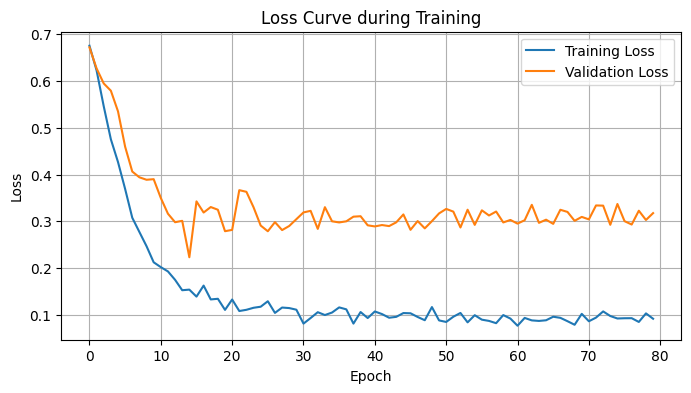

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
model_name = "best_loss_model.pth"

# model = MLP(input_size=input_shape[1]).to(device)
# model = MLP(input_size=input_shape[1]*input_shape[2]).to(device)
# model = CNN_MLP(input_channels=input_shape[1], input_time=input_shape[2]).to(device)

# 使用新的 Bi-LSTM 模型
model = DCNN_BiLSTM(input_channels=input_shape[1], input_time=input_shape[2]).to(device)

with torch.no_grad():
    dummy = torch.zeros(32, 23, 1280).float().to(device)
    _ = model(dummy)
model.load_state_dict(torch.load(model_name))
y_true, y_prob, y_pred = [], [], []
model.eval()
if model_name == "best_loss_model.pth":
  threshold = config["eval"]["threshold_bestloss"]
elif model_name == "best_model.pth":
  threshold = config["eval"]["threshold_best"]
elif model_name == "last_model.pth":
  threshold = config["eval"]["threshold_last"]
print(f'best threshold: {threshold}')

with torch.no_grad():
    for X, y in tqdm(test_loader):
        X = X.float().to(device)
        y = y.float().to(device)

        logits = model(X).view(-1)
        # for metrics
        y_true.extend(y.cpu().numpy())
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).long()
        # print(probs)
        y_pred.extend(preds.cpu().numpy().reshape(-1))
        y_prob.extend(probs.cpu().detach().numpy().reshape(-1))
    print('\n')
    test_results = basic_metric(y_true, y_pred, y_prob, metrics=['all'])

CNN Output Shape: torch.Size([1, 32, 2, 158])
LSTM Input Features: 64, Seq Len: 158
best threshold: 0.9


100%|██████████| 83/83 [00:00<00:00, 94.91it/s]



accuracy   : 0.9703
recall     : 0.9500
precision  : 0.7125
specificity: 0.9718
AUC        : 0.9907
F1_score   : 0.8143
fpr        : 0.0282


## Tools

### Reload file

In [60]:
import importlib
import dataset

importlib.reload(dataset)

<module 'dataset' from '/Users/kimi/Documents/GitHub/seizure_pred/main/dataset.py'>